<a href="https://colab.research.google.com/github/vsoos/CloudComputing/blob/main/ex1/advanced_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced extra task 1 - Spam filter with BERT

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
import numpy as np
import os

In [ ]:
folder_path = '/content/drive/MyDrive/cloudcomputing2023_VincenzinaSoos/ex1'
os.chdir(folder_path)

In [ ]:
df = pd.read_csv('data/emails.csv')
# remove Subject
df['Text'] = df['Text'].str.replace('Subject:', '', regex=False)
df.dropna(inplace=True)

# Split dataset into train/test (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(df['Text'], df['Spam'], test_size=0.2, random_state=42)

In [ ]:
df.head()

,Text,Spam
0,naturally irresistible your corporate identit...,1
1,the stock trading gunslinger fanny is merril...,1
2,unbelievable new homes made easy im wanting ...,1
3,4 color printing special request additional ...,1
4,"do not have money , get software cds from her...",1


In [ ]:
from google.colab import userdata
userdata.get('HF_TOKEN') # fetch huggingface token from colab userdata
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# tokenize a list of texts into bert-compatible inputs
def tokenize_text(texts):
    tokens = tokenizer(texts.tolist(),
                       max_length=128,
                       truncation=True,
                       padding=True,
                       add_special_tokens=True,
                       return_tensors='tf' # return tensors for tensorflow
                       )
    return tokens

X_train_tokens = tokenize_text(X_train)
X_test_tokens = tokenize_text(X_test)

# create embeddings for input tokens using bert model
def create_embeddings(tokens, batch_size=32):
    all_embeddings = [] # store all embeddings
    # process tokens in batches for efficiency
    for i in range(0, len(tokens['input_ids']), batch_size):
      # extract batch tokens for input
        batch_tokens = {key: val[i:i + batch_size] for key, val in tokens.items()}
        # get [CLS] token
        batch_embeddings = bert_model(batch_tokens)[0][:, 0, :]
        all_embeddings.append(batch_embeddings)
    return tf.concat(all_embeddings, axis=0) # concat all embeddings

# generate embeddings
X_train_embeddings = create_embeddings(X_train_tokens)
X_test_embeddings = create_embeddings(X_test_tokens)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(768,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 164481 (642.50 KB)
Trainable params: 164481 (642.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train_embeddings, Y_train, epochs=7, batch_size=16, validation_split=0.1)

Epoch 1/7
258/258 [==============================] - 4s 6ms/step - loss: 0.2707 - accuracy: 0.8821 - val_loss: 0.1229 - val_accuracy: 0.9477
Epoch 2/7
258/258 [==============================] - 1s 6ms/step - loss: 0.0902 - accuracy: 0.9660 - val_loss: 0.0812 - val_accuracy: 0.9717
Epoch 3/7
258/258 [==============================] - 1s 4ms/step - loss: 0.0574 - accuracy: 0.9794 - val_loss: 0.0806 - val_accuracy: 0.9673
Epoch 4/7
258/258 [==============================] - 1s 4ms/step - loss: 0.0488 - accuracy: 0.9816 - val_loss: 0.0740 - val_accuracy: 0.9739
Epoch 5/7
258/258 [==============================] - 1s 4ms/step - loss: 0.0364 - accuracy: 0.9869 - val_loss: 0.0587 - val_accuracy: 0.9760
Epoch 6/7
258/258 [==============================] - 1s 4ms/step - loss: 0.0256 - accuracy: 0.9918 - val_loss: 0.0631 - val_accuracy: 0.9782
Epoch 7/7
258/258 [==============================] - 1s 4ms/step - loss: 0.0219 - accuracy: 0.9937 - val_loss: 0.0599 - val_accuracy: 0.9782


In [ ]:
# Evaluate on the test set
test_predictions = (model.predict(X_test_embeddings) > 0.5).astype("int32")

36/36 [==============================] - 0s 2ms/step


In [ ]:
# Classification report
print(classification_report(Y_test, test_predictions, target_names=['Not Spam', 'Spam']))

              precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99       856
        Spam       0.97      0.97      0.97       290

    accuracy                           0.99      1146
   macro avg       0.98      0.98      0.98      1146
weighted avg       0.99      0.99      0.99      1146



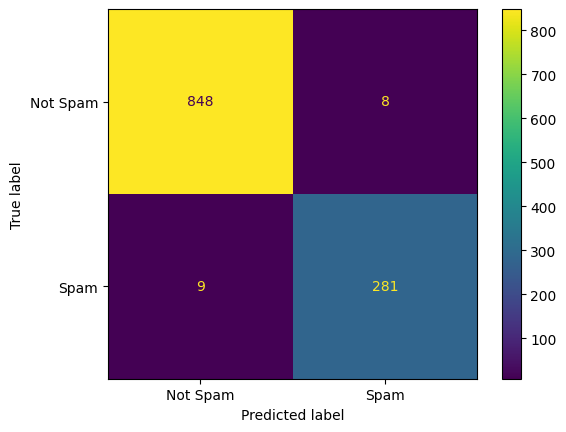

In [ ]:
# Confusion matrix
cm = confusion_matrix(Y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot()
plt.show()

In [ ]:
# Model testing with sample emails
sample_emails = ["Win a free trip to BoraBora!!!!!",
                 "The new MacStudios are available at iStyle",
                 "Regarding you Thesis proposal (Urgent)...",
                 "How to get rich with BitCoin fast!"]

sample_tokens = tokenizer(sample_emails, max_length=128, truncation=True, padding=True, add_special_tokens=True, return_tensors='tf')
sample_embeddings = create_embeddings(sample_tokens)
sample_predictions = (model.predict(sample_embeddings) > 0.5).astype("int32")

for email, label in zip(sample_emails, sample_predictions):
    print(f'Email: "{email}"\nPrediction: {["Not Spam", "Spam"][label[0]]}\n')

1/1 [==============================] - 0s 17ms/step
Email: "Win a free trip to BoraBora!!!!!"
Prediction: Spam

Email: "The new MacStudios are available at iStyle"
Prediction: Not Spam

Email: "Regarding you Thesis proposal (Urgent)..."
Prediction: Spam

Email: "How to get rich with BitCoin fast!"
Prediction: Spam

